In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import pearsonr

# Load dataset

In [94]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])
X.shape, y.shape

((70000, 28, 28), (70000,))

# Plot a few images

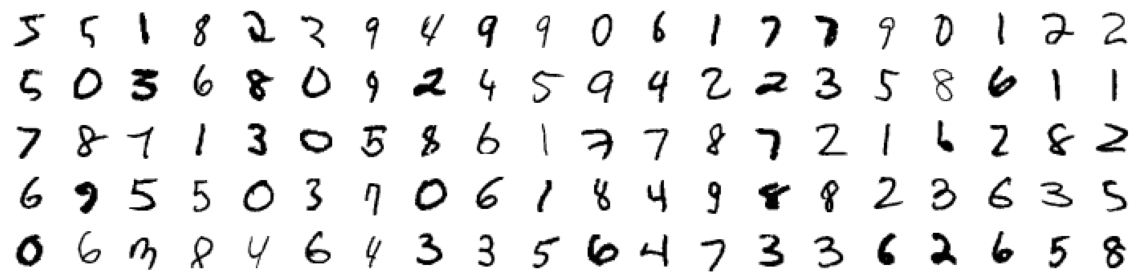

In [95]:
fig, axes = plt.subplots(5, 20, figsize=(16, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X[::100][i], cmap='binary')
    ax.axis('off')
    ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## Reduce data size with PCA to accelerate correlation comparison

In [96]:
from sklearn.decomposition import PCA
pca = PCA(100)

In [97]:
X_flat = X.reshape(len(X), -1)
X_flat.shape

(70000, 784)

In [98]:
%%time
X_pca = pca.fit_transform(X_flat)

CPU times: user 20.3 s, sys: 2.24 s, total: 22.5 s
Wall time: 4.47 s


In [99]:
comp = pca.components_.reshape(-1, *X.shape[1:])
comp = comp - comp.min((1, 2)).reshape(-1, 1, 1)
comp = comp / comp.max((1, 2)).reshape(-1, 1, 1)

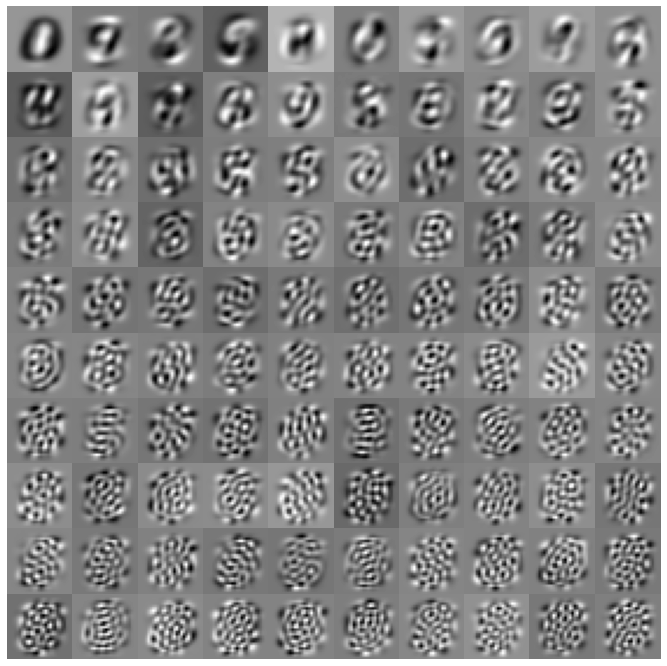

In [100]:
fig, axes = plt.subplots(10, 10, figsize=(11.7, 12))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(comp[i], cmap='binary')
    ax.axis('off')
    ax.set_aspect('equal')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [101]:
from umap import UMAP
umap = UMAP(n_components=50)
X_umap = umap.fit_transform(X_pca)

# Exploration

Take one entry and find most correlated samples.

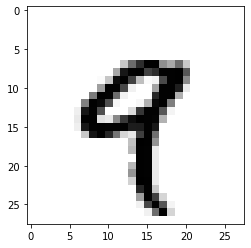

In [102]:
idx = 4
excerpt_img = X[idx]
excerpt_umap = X_umap[idx]
plt.imshow(excerpt_img, cmap='binary')

Mostly works, but not always. Some errors should be exaptable, but let's go a step further and increase the threshold to 0.90 correlation and collect clusters for the first few 100 entries.

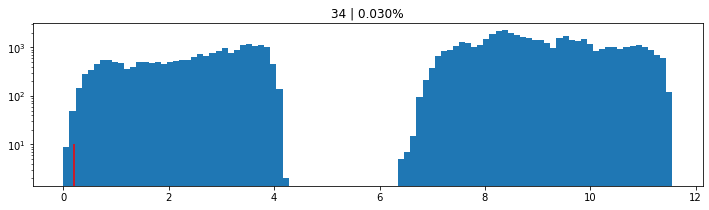

In [103]:
thresh = 0.2
excerpt_norm = np.linalg.norm(X_umap - excerpt_umap.ravel(), axis=1)
hit_mask = excerpt_norm<thresh
hits = np.sum(hit_mask) - 1
high_corr = sorted(excerpt_norm)[1]
plt.figure(figsize=(12, 3))
plt.title(f'{hits} | {high_corr:.3f}%')
plt.hist(excerpt_norm, bins=100, log=True);
plt.vlines(thresh, 0, 10, colors='r')
plt.show()

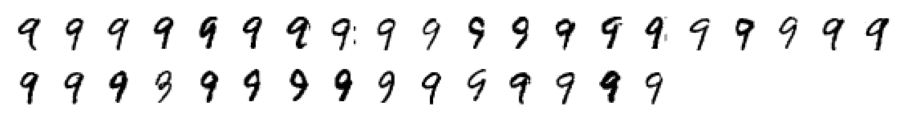

In [104]:
corr_img = X[hit_mask]

nrows = int(np.ceil(len(corr_img)/20))
fig, axes = plt.subplots(nrows, 20, figsize=(16, 1.*nrows))
for i, ax in enumerate(axes.flatten()):
    try:
        ax.imshow(corr_img[i], cmap='binary')
        ax.axis('off')
        ax.set_aspect('equal')
    except:
        ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Go through data and collect clusters

In [105]:
from sklearn.metrics.pairwise import euclidean_distances

In [106]:
excerpt = X_umap[::10]

In [107]:
%%time
excerpt_norm = euclidean_distances(excerpt, X_umap)
excerpt_norm.shape

CPU times: user 18.5 s, sys: 9.98 s, total: 28.4 s
Wall time: 9.21 s


(7000, 70000)

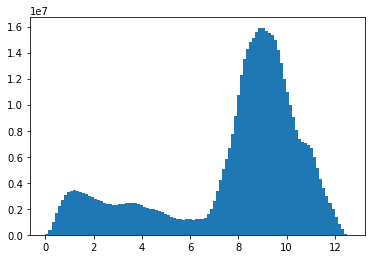

In [108]:
plt.hist(excerpt_norm.ravel(), bins=100);

In [116]:
norm_thresh = np.percentile(excerpt_norm, 1)
norm_thresh

0.6085190761089325

In [117]:
masks = excerpt_norm<norm_thresh
masks.shape

(7000, 70000)

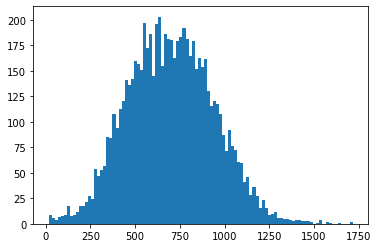

In [118]:
masks_hit = np.sum(masks,axis=1)
plt.hist(masks_hit, bins=100);

In [119]:
templates = []

n_temp = 60
for n in tqdm(range(n_temp)):
    big_idx = np.argmax(masks_hit)
    temp_mask = masks[big_idx]
    print(n, temp_mask.sum())
    templates.append(X[temp_mask])
    masks[:, temp_mask] = False
    masks_hit = np.sum(masks,axis=1)

  0%|          | 0/60 [00:00<?, ?it/s]

0 1717
1 1712
2 1420
3 1353
4 1290
5 1285
6 1242
7 1233
8 1217
9 1212
10 1190
11 1177
12 1173
13 1140
14 1134
15 1123
16 1121
17 1088
18 1068
19 1059
20 1037
21 1019
22 948
23 924
24 882
25 876
26 855
27 849
28 846
29 842
30 833
31 808
32 782
33 753
34 742
35 731
36 719
37 717
38 699
39 691
40 690
41 674
42 669
43 661
44 649
45 636
46 605
47 588
48 575
49 554
50 553
51 541
52 540
53 523
54 510
55 504
56 494
57 493
58 444
59 431


0 1717


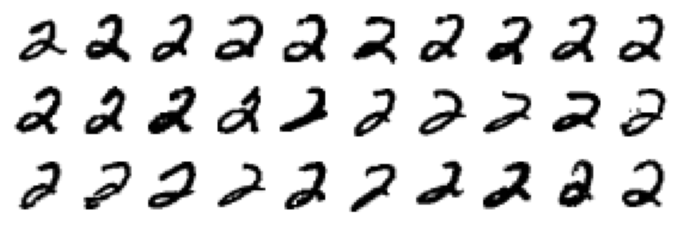

1 1712


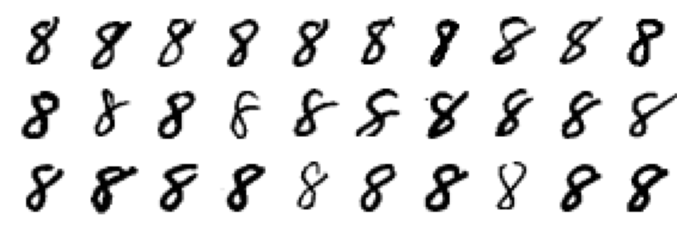

2 1420


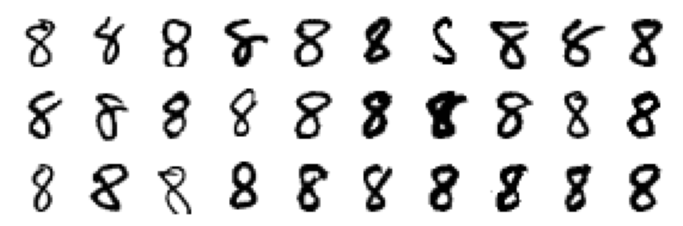

3 1353


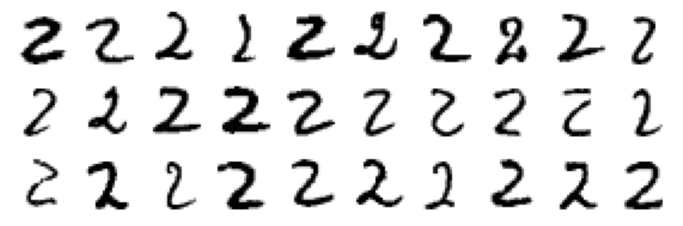

4 1290


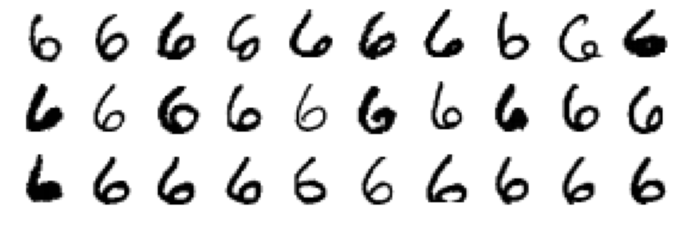

5 1285


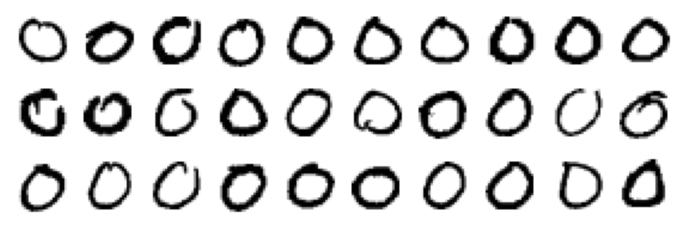

6 1242


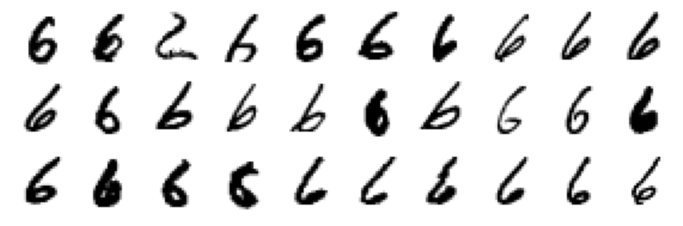

7 1233


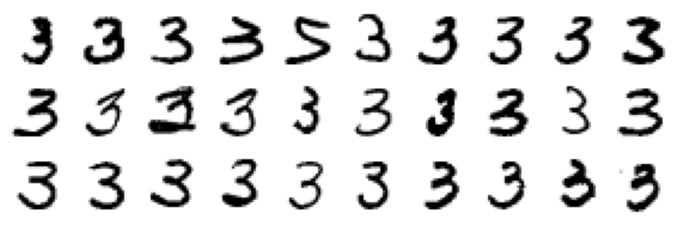

8 1217


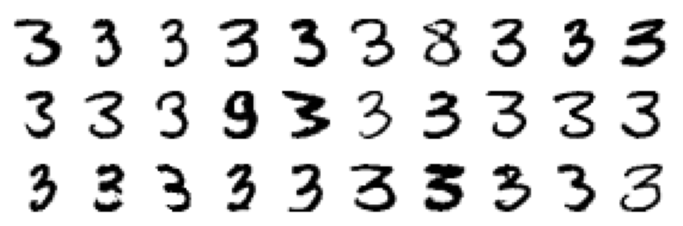

9 1212


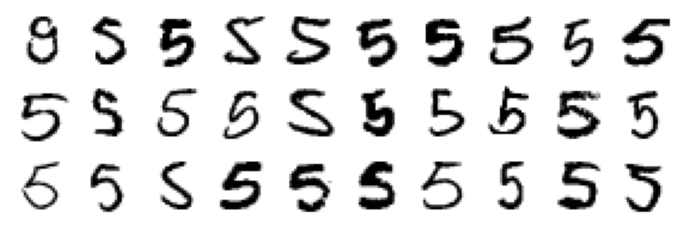

In [120]:
for i, t in enumerate(templates[:10]):
    print(i, len(t))
    fig, axes = plt.subplots(3, 10, figsize=(12, 4))
    for i, ax in enumerate(axes.flatten()):
        try:
            ax.imshow(t[i], cmap='binary')
        except:
            pass
        ax.axis('off')
        ax.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

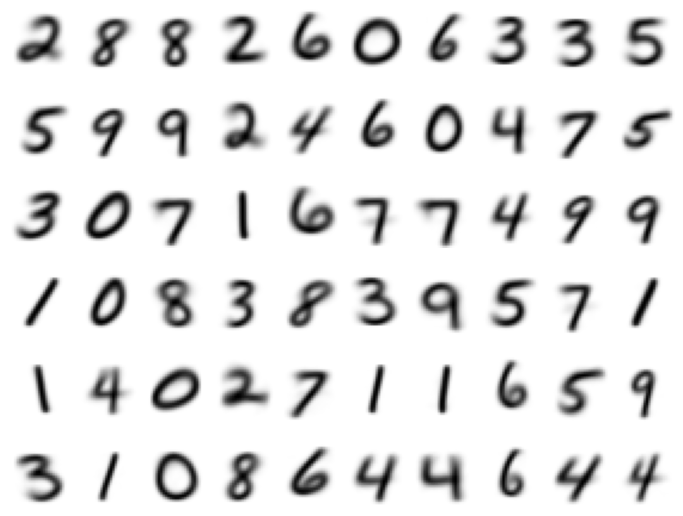

In [121]:
nrows = int(np.ceil(len(templates)/10))
fig, axes = plt.subplots(nrows, 10, figsize=(12, 1.6*nrows))

template_mean = []

for i, ax in enumerate(axes.flatten()):
    try:
        mean_img = np.mean(templates[i], axis=0)
        template_mean.append(mean_img)
        ax.imshow(mean_img, cmap='binary')
    except:
        pass
    ax.axis('off')
    ax.set_aspect('equal')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

template_mean = np.array(template_mean)

# Manual template labeling

In [122]:
template_label = [
2,8,8,2,6,0,6,3,3,5,
5,9,9,2,4,6,0,4,7,5,
3,0,7,1,6,7,7,4,9,9,
1,0,8,3,8,3,9,5,7,1,
1,4,0,2,7,1,1,6,5,9,
3,1,0,8,6,4,4,6,4,4,
]

In [123]:
templates_clean = [t for i, t in enumerate(templates) if template_label[i] >= 0]
template_label = [t for t in template_label if t >= 0]
len(templates_clean)

60

In [124]:
sublabels = np.concatenate([len(t)*[template_label[i]] for i, t in enumerate(templates_clean)])
sublabels

array([2, 2, 2, ..., 4, 4, 4])

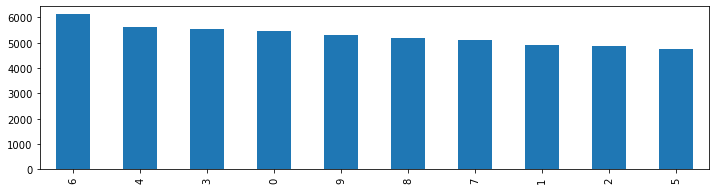

In [125]:
pd.value_counts(sublabels).plot(kind='bar', figsize=(12, 3));

# Image classification

In [126]:
# Create subset of faces
subset = np.concatenate(templates_clean)
subset.shape, sublabels.shape

((52841, 28, 28), (52841,))

In [127]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [128]:
data_augmentation = keras.Sequential(
    [
        layers.RandomZoom(height_factor=(-0.1, 0.1)),
        layers.RandomRotation(0.1),
    ]
)

In [129]:
def make_model(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)
    
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128)(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(32)(x)
    x = layers.Activation("relu")(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [130]:
model = make_model(input_shape=subset.shape[1:] + (1,),
                   num_classes=len(np.unique(sublabels)))

In [131]:
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(
    subset, sublabels, test_size=0.2, shuffle=True, stratify=sublabels)

In [132]:
earlystopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    x=x_tr,
    y=y_tr,
    epochs=100,
    batch_size=64,
    validation_data=(x_te, y_te),
    callbacks=[earlystopping_cb],
    verbose=1)

Epoch 1/100
661/661 [==============================] - 15s 22ms/step - loss: 0.7406 - accuracy: 0.7414 - val_loss: 0.1150 - val_accuracy: 0.9727
Epoch 2/100
661/661 [==============================] - 14s 21ms/step - loss: 0.1781 - accuracy: 0.9522 - val_loss: 0.0947 - val_accuracy: 0.9792
Epoch 3/100
661/661 [==============================] - 14s 22ms/step - loss: 0.1414 - accuracy: 0.9647 - val_loss: 0.0767 - val_accuracy: 0.9823
Epoch 4/100
661/661 [==============================] - 14s 22ms/step - loss: 0.1090 - accuracy: 0.9704 - val_loss: 0.1078 - val_accuracy: 0.9780
Epoch 5/100
661/661 [==============================] - 14s 21ms/step - loss: 0.1021 - accuracy: 0.9740 - val_loss: 0.0918 - val_accuracy: 0.9816
Epoch 6/100
661/661 [==============================] - 14s 22ms/step - loss: 0.0931 - accuracy: 0.9753 - val_loss: 0.0738 - val_accuracy: 0.9862
Epoch 7/100
661/661 [==============================] - 15s 23ms/step - loss: 0.0840 - accuracy: 0.9791 - val_loss: 0.1165 - val_ac

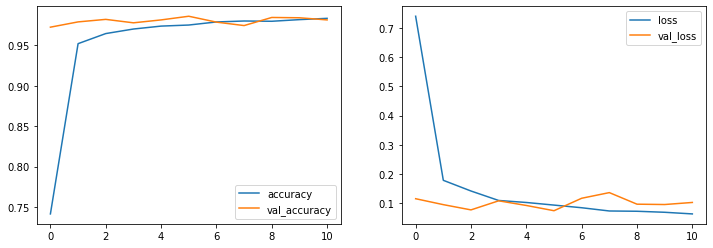

In [133]:
# Plots neural network performance metrics for train and validation
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
results = pd.DataFrame(history.history)
results[["accuracy", "val_accuracy"]].plot(ax=axs[0])
results[["loss", "val_loss"]].plot(ax=axs[1])
plt.show()

In [134]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, include_values=False, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize="true", include_values=False, ax=ax2)

    plt.show()

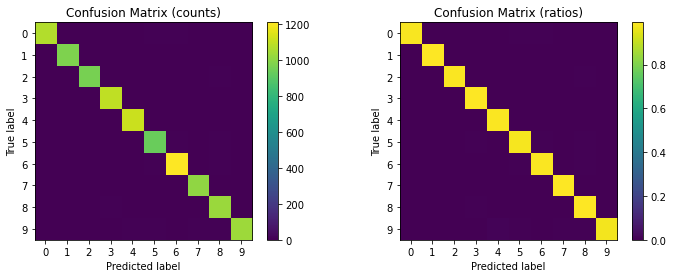

In [135]:
# Compute test set predictions
predictions = np.argmax(model.predict(x_te), axis=1)

# Plot confusion matrices
plot_confusion_matrices(y_te, predictions)

# Predict full dataset

In [136]:
pred_full = model.predict(X)
pred_full.shape

(70000, 10)

In [137]:
pred_label = np.argmax(pred_full, axis=1)
pred_label

array([5, 0, 4, ..., 4, 5, 6])

In [138]:
np.mean(y==pred_label)

0.9666142857142858

In [139]:
proba = np.array([p[pred_label[i]] for i, p in enumerate(pred_full)])

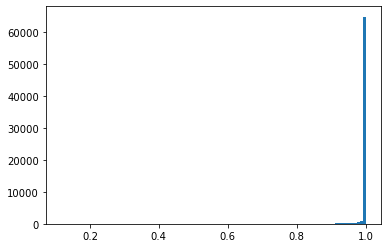

In [140]:
plt.hist(proba, bins=100);

In [146]:
prob_thresh = 1-1e-3
thresh_sure = np.mean(proba>prob_thresh)
thresh_sure

0.8869714285714285

# Collect certain labels

In [147]:
mask_prob = proba>prob_thresh
mask_prob

array([ True,  True,  True, ...,  True,  True,  True])

In [148]:
bigset = X[mask_prob]
biglabel = pred_label[mask_prob]
bigset.shape, biglabel.shape

((62088, 28, 28), (62088,))

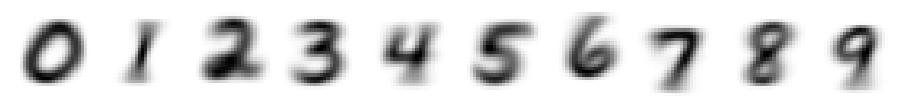

In [149]:
fig, axes = plt.subplots(1, len(np.unique(biglabel)), figsize=(16, 2))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.mean(bigset[biglabel==i]/255, 0), cmap='binary')
    ax.axis('off')
    ax.set_aspect('equal')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

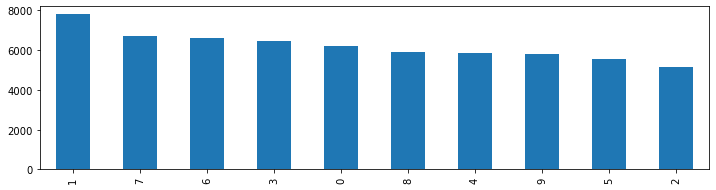

In [150]:
pd.value_counts(biglabel).plot(kind='bar', figsize=(12, 3));

# Check for new classes by looking only on the difficult cases

In [151]:
not_sure_thresh = (1-thresh_sure)*100
not_sure_thresh

11.302857142857148

In [152]:
low_thresh = np.percentile(proba, not_sure_thresh)
low_thresh

0.9990003549712045

In [153]:
mask = proba<prob_thresh
X_hard = X[mask]

In [154]:
X_hard.shape

(7912, 28, 28)

In [155]:
from sklearn.decomposition import PCA
pca = PCA(100)

In [156]:
X_flat_hard = X_hard.reshape(len(X_hard), -1)
X_flat_hard.shape

(7912, 784)

In [157]:
%%time
X_pca_hard = pca.fit_transform(X_flat_hard)

CPU times: user 2.17 s, sys: 274 ms, total: 2.45 s
Wall time: 415 ms


In [158]:
comp = pca.components_.reshape(-1, *X_hard.shape[1:])
comp = comp - comp.min((1, 2)).reshape(-1, 1, 1)
comp = comp / comp.max((1, 2)).reshape(-1, 1, 1)

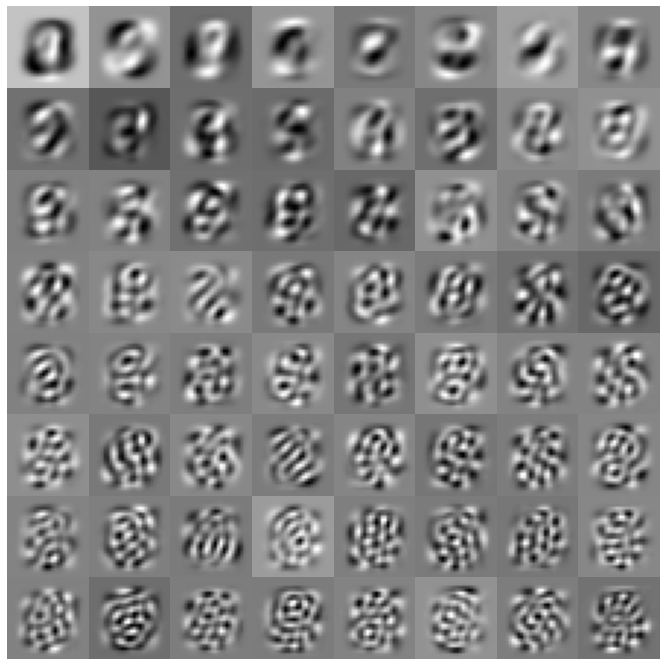

In [159]:
fig, axes = plt.subplots(8, 8, figsize=(11.7, 12))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(comp[i], cmap='binary')
    ax.axis('off')
    ax.set_aspect('equal')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [160]:
umap = UMAP(n_components=50)
X_umap_hard = umap.fit_transform(X_pca_hard)

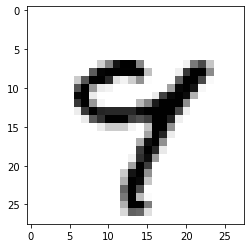

In [161]:
idx = 4
excerpt_img = X_hard[idx]
excerpt_umap = X_umap_hard[idx]
plt.imshow(excerpt_img, cmap='binary')

In [162]:
excerpt = X_umap_hard.copy()

In [163]:
%%time
excerpt_norm = euclidean_distances(excerpt, X_umap_hard)
excerpt_norm.shape

CPU times: user 3.5 s, sys: 772 ms, total: 4.28 s
Wall time: 761 ms


(7912, 7912)

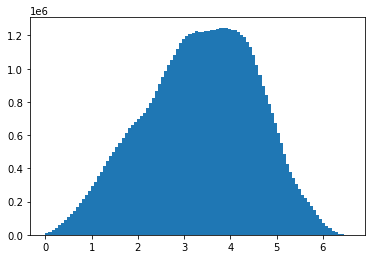

In [164]:
plt.hist(excerpt_norm.ravel(), bins=100);

In [165]:
norm_thresh = np.percentile(excerpt_norm, 1)
norm_thresh

0.6280383855104448

In [166]:
masks = excerpt_norm<norm_thresh
masks.shape

(7912, 7912)

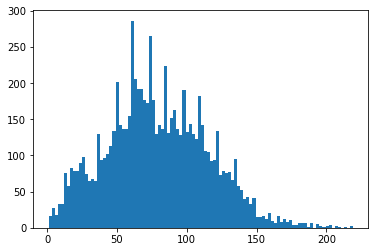

In [167]:
masks_hit = np.sum(masks,axis=1)
plt.hist(masks_hit, bins=100);

In [168]:
templates_hard = []

n_temp = 60
for n in tqdm(range(n_temp)):
    big_idx = np.argmax(masks_hit)
    temp_mask = masks[big_idx]
    print(n, temp_mask.sum())
    templates_hard.append(X_hard[temp_mask])
    masks[:, temp_mask] = False
    masks_hit = np.sum(masks,axis=1)

  0%|          | 0/60 [00:00<?, ?it/s]

0 219
1 193
2 165
3 164
4 160
5 160
6 160
7 157
8 155
9 149
10 146
11 140
12 139
13 134
14 133
15 132
16 127
17 123
18 115
19 114
20 113
21 110
22 106
23 101
24 101
25 97
26 92
27 90
28 90
29 85
30 85
31 85
32 85
33 83
34 79
35 79
36 78
37 78
38 76
39 76
40 75
41 72
42 72
43 71
44 69
45 66
46 66
47 64
48 61
49 61
50 61
51 59
52 57
53 52
54 50
55 49
56 49
57 49
58 45
59 45


0 219


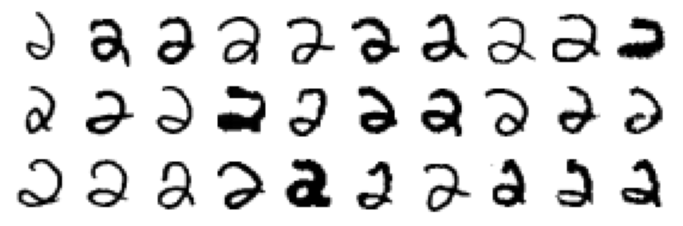

1 193


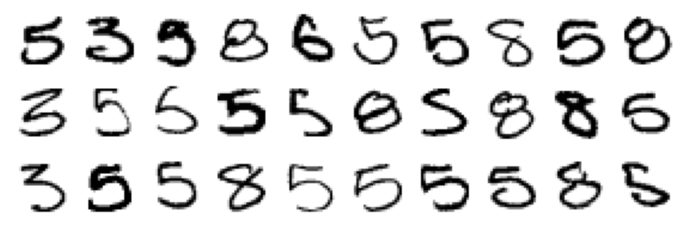

2 165


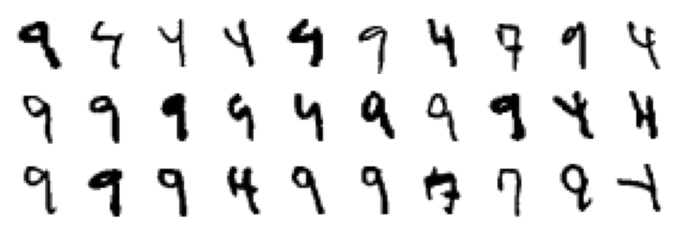

3 164


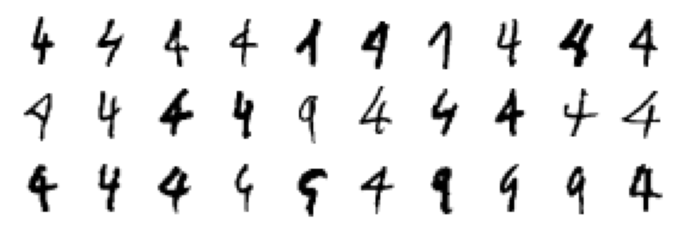

4 160


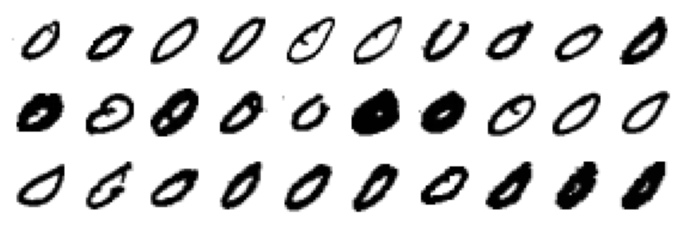

5 160


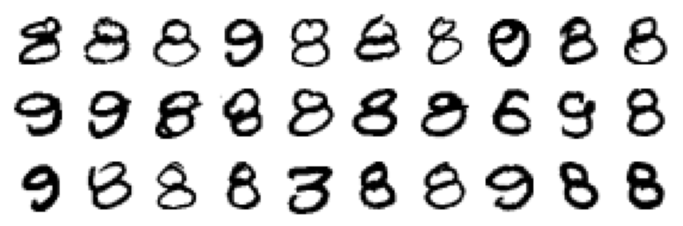

6 160


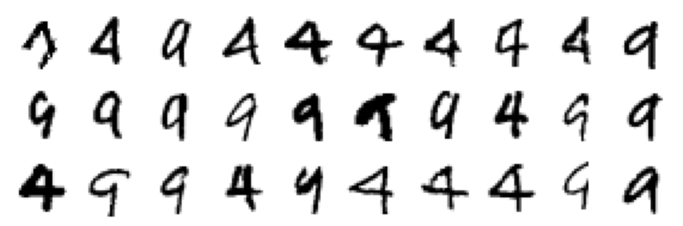

7 157


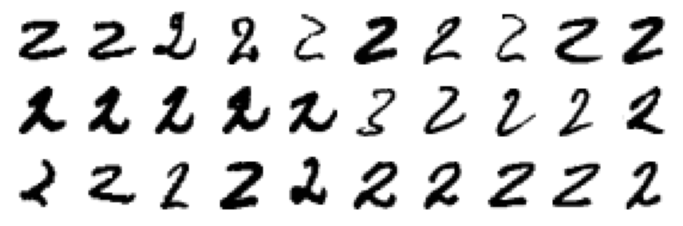

8 155


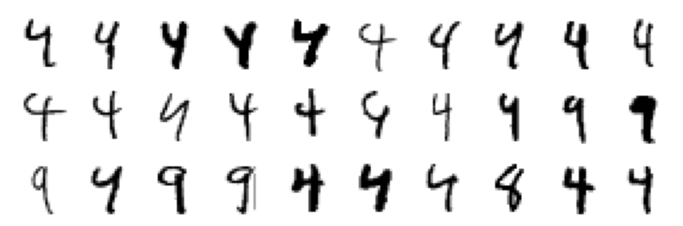

9 149


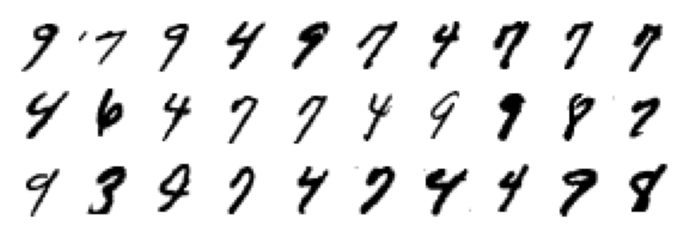

In [169]:
for i, t in enumerate(templates_hard[:10]):
    print(i, len(t))
    fig, axes = plt.subplots(3, 10, figsize=(12, 4))
    for i, ax in enumerate(axes.flatten()):
        try:
            ax.imshow(t[i], cmap='binary')
        except:
            pass
        ax.axis('off')
        ax.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

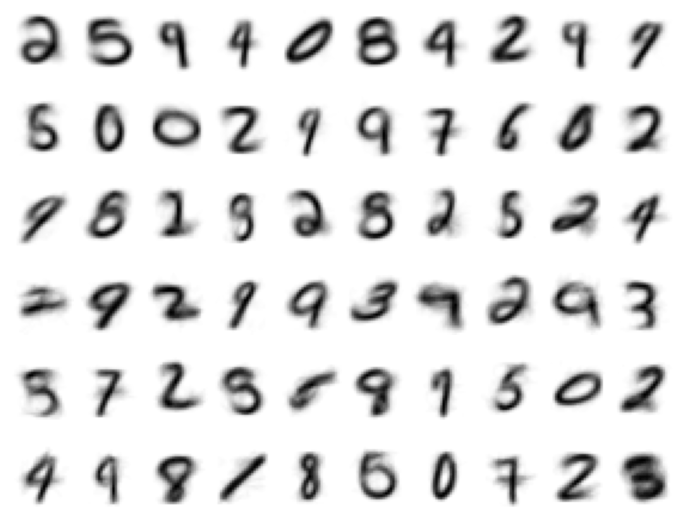

In [170]:
nrows = int(np.ceil(len(templates_hard)/10))
fig, axes = plt.subplots(nrows, 10, figsize=(12, 1.6*nrows))

template_mean_hard = []

for i, ax in enumerate(axes.flatten()):
    try:
        mean_img = np.mean(templates_hard[i], axis=0)
        template_mean_hard.append(mean_img)
        ax.imshow(mean_img, cmap='binary')
    except:
        pass
    ax.axis('off')
    ax.set_aspect('equal')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

template_mean_hard = np.array(template_mean_hard)

# Manual template labeling

In [171]:
template_label_hard = [
2,5,9,4,0,8,4,2,-1,-1,
-1,0,0,2,9,9,7,6,0,2,
9,8,1,-1,2,-1,2,-1,2,4,
-1,9,2,9,9,3,-1,2,9,3,
-1,-1,2,-1,-1,9,-1,-1,0,2,
4,-1,8,1,8,-1,0,7,2,-3,
]

In [172]:
templates_clean_hard = [t for i, t in enumerate(templates_hard) if template_label_hard[i] >= 0]
template_label_hard = [t for t in template_label_hard if t >= 0]
len(templates_clean_hard)

43

In [173]:
sublabels_hard = np.concatenate([len(t)*[template_label_hard[i]] for i, t in enumerate(templates_clean_hard)])
sublabels_hard

array([2, 2, 2, ..., 2, 2, 2])

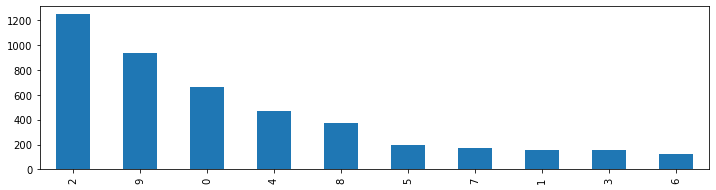

In [174]:
pd.value_counts(sublabels_hard).plot(kind='bar', figsize=(12, 3));

# Combine the two datasets

In [175]:
data_full = np.concatenate([subset, np.concatenate(templates_clean_hard)])
data_full.shape

(57337, 28, 28)

In [176]:
labels_part1 = sublabels.tolist()
labels_part2 = sublabels_hard.tolist()
labels_full = np.array(labels_part1 + labels_part2)
len(labels_full), np.unique(labels_full)

(57337, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

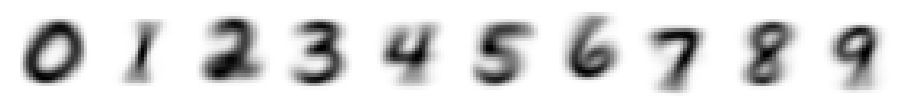

In [177]:
fig, axes = plt.subplots(1, len(np.unique(labels_full)), figsize=(16, 2))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.mean(data_full[labels_full==i]/255, 0), cmap='binary')
    ax.axis('off')
    ax.set_aspect('equal')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

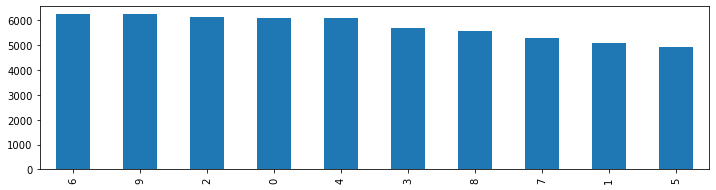

In [178]:
pd.value_counts(labels_full).plot(kind='bar', figsize=(12, 3));

In [179]:
model = make_model(input_shape=data_full.shape[1:] + (1,),
                   num_classes=len(np.unique(labels_full)))

In [180]:
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(
    data_full, labels_full, test_size=0.2, shuffle=True, stratify=labels_full)

In [181]:
earlystopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    x=x_tr,
    y=y_tr,
    epochs=100,
    batch_size=128,
    validation_data=(x_te, y_te),
    callbacks=[earlystopping_cb],
    verbose=1)

Epoch 1/100
359/359 [==============================] - 13s 35ms/step - loss: 0.8826 - accuracy: 0.7004 - val_loss: 0.1920 - val_accuracy: 0.9529
Epoch 2/100
359/359 [==============================] - 13s 35ms/step - loss: 0.2789 - accuracy: 0.9292 - val_loss: 0.1653 - val_accuracy: 0.9614
Epoch 3/100
359/359 [==============================] - 13s 36ms/step - loss: 0.2223 - accuracy: 0.9445 - val_loss: 0.1577 - val_accuracy: 0.9602
Epoch 4/100
359/359 [==============================] - 15s 42ms/step - loss: 0.1942 - accuracy: 0.9523 - val_loss: 0.1378 - val_accuracy: 0.9656
Epoch 5/100
359/359 [==============================] - 13s 37ms/step - loss: 0.1725 - accuracy: 0.9565 - val_loss: 0.1534 - val_accuracy: 0.9610
Epoch 6/100
359/359 [==============================] - 13s 35ms/step - loss: 0.1576 - accuracy: 0.9577 - val_loss: 0.1335 - val_accuracy: 0.9683
Epoch 7/100
359/359 [==============================] - 13s 35ms/step - loss: 0.1505 - accuracy: 0.9591 - val_loss: 0.1641 - val_ac

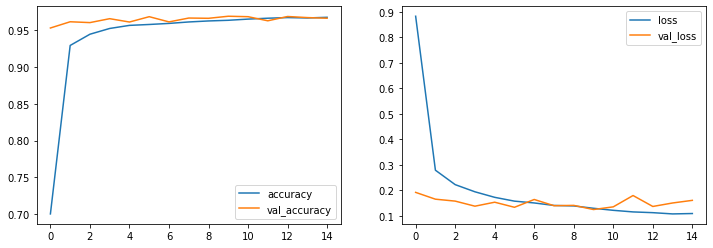

In [182]:
# Plots neural network performance metrics for train and validation
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
results = pd.DataFrame(history.history)
results[["accuracy", "val_accuracy"]].plot(ax=axs[0])
results[["loss", "val_loss"]].plot(ax=axs[1])
plt.show()

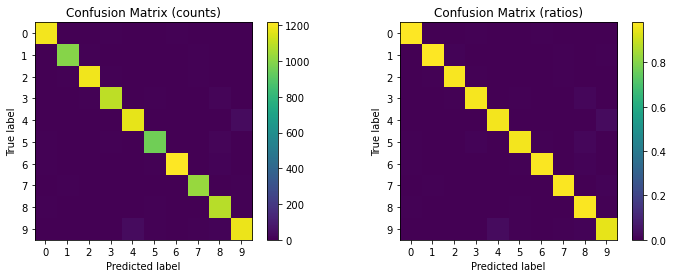

In [183]:
# Compute test set predictions
predictions = np.argmax(model.predict(x_te), axis=1)

# Plot confusion matrices
plot_confusion_matrices(y_te, predictions)

# Predict full dataset

In [184]:
pred_full = model.predict(X)
pred_full.shape

(70000, 10)

In [185]:
pred_label = np.argmax(pred_full, axis=1)
pred_label

array([5, 0, 4, ..., 4, 5, 6])

In [186]:
np.mean(y==pred_label)

0.9636571428571429

In [187]:
proba = np.array([p[pred_label[i]] for i, p in enumerate(pred_full)])

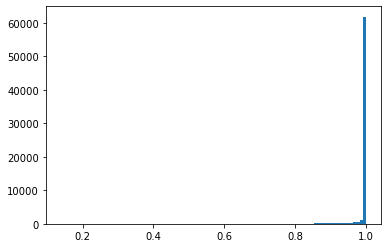

In [188]:
plt.hist(proba, bins=100);

In [189]:
prob_thresh = 1-1e-3
np.mean(proba>prob_thresh)

0.8245142857142858

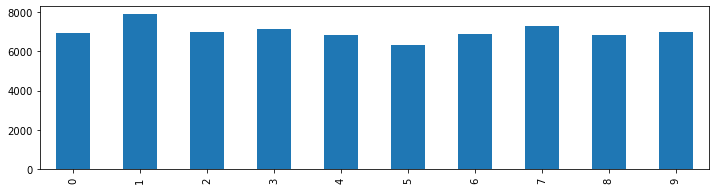

In [190]:
pd.value_counts(y).sort_index().plot(kind='bar', figsize=(12, 3));

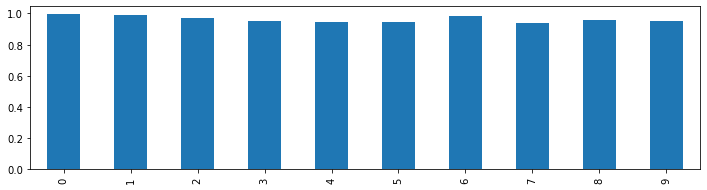

In [192]:
# Which labels was difficult to find?
pred_correct = y[y==pred_label]

(pd.value_counts(pred_correct)/pd.value_counts(y)).plot(kind='bar', figsize=(12, 3));

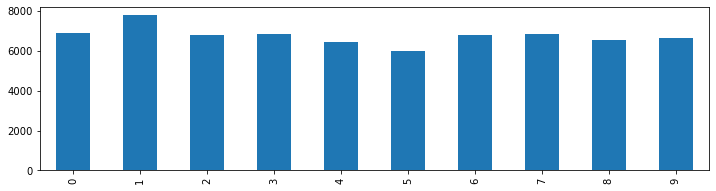

In [194]:
# Distribution of predictions
pd.value_counts(pred_correct).sort_index().plot(kind='bar', figsize=(12, 3));